In [ ]:
import os
import shutil

def clear_directory(directory):
    # List all files and directories in the given directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        try:
            # If it is a file, delete it
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            # If it is a directory, delete it and all its contents
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
            print(f"Deleted {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}. Reason: {e}")

# Usage: Clearing the current working directory
clear_directory('.')


Deleted ./.config
Deleted ./patches_T5_first_data1
Deleted ./.ipynb_checkpoints
Deleted ./patches_BART_first_data1
Deleted ./results
Deleted ./patches_GPT2_first_data
Deleted ./patches_BART_second_data.zip
Deleted ./patches_BART_first_data.zip
Failed to delete ./drive. Reason: [Errno 125] Operation canceled: '.file-revisions-by-id'
Deleted ./patches_BART_second_data
Deleted ./patches_GPT2_first_data.zip
Deleted ./patches_T5_first_data.zip
Deleted ./patches_GPT2_first_data1
Deleted ./sample_data


In [1]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install transformers -U
!pip uninstall transformers accelerate
!pip install transformers accelerate
!pip install torch -U
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [3]:
from accelerate import Accelerator
accelerator = Accelerator()
print("Accelerate device:", accelerator.device)

Accelerate device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/buggy/bugs'
with open(file_path, 'r') as file:
    sample_content = file.read()

len(sample_content)


81272455

#First dataset_BART Model

In [ ]:
import torch
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()


gc.collect()

torch.cuda.reset_peak_memory_stats()

print("GPU memory cleared")

GPU memory cleared


In [ ]:
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return description, patch

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            original, patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print("Buggy Code (Red):")
            print(f"\033[91m{original}\033[0m")
            print("Generated Patch (Green and Red):")
            display_comparisons(original, patch)
            print("\n")

if __name__ == "__main__":
    main()


<ipython-input-7-b4c688bfa038>:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return load_metric("accuracy", trust_remote_code=True)


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: report(n, MISPLACED_ANNOTATION);
Example of fixed code: report(n, MISPLACED_ANNOTATION, "@abstract",



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

GPU memory cleared


<ipython-input-4-5d7a9f12ea7c>:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return load_metric("accuracy", trust_remote_code=True)


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Number of buggy codes in training: 395405
Number of fixed codes in training: 396364
Number of buggy codes in validation: 43839
Number of fixed codes in validation: 43364
Example of buggy code from training: return "redirect:" + VISIT_FORM_URL + ".form?visitId=" + visit.getVisitId();
Example of fixed code from training: + visit.getPatient().getPatientId();



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.637100,4.293815
2,1.368200,5.502994
3,1.297700,7.446701
4,1.280600,6.390741
5,1.270300,6.487727
6,1.242800,7.217824
7,1.185500,7.712296
8,1.177900,8.733116
9,1.184800,3.720177
10,1.184400,6.007297


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Results Statistics:
eval_loss: 6.007297039031982
eval_runtime: 3.0172
eval_samples_per_second: 227.365
eval_steps_per_second: 28.503
epoch: 10.0
Execution Time: 1545.97 seconds


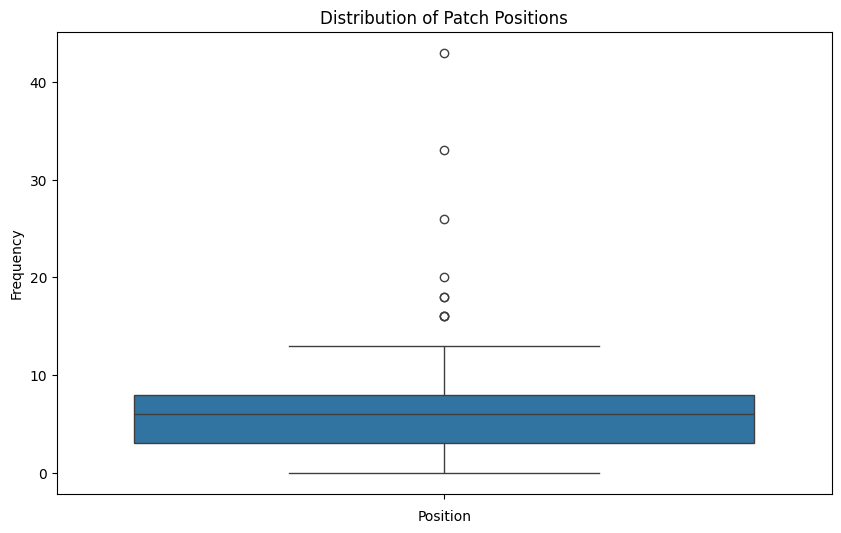

Max Execution Time: 0.71 seconds
Min Execution Time: 0.57 seconds
Average Execution Time: 0.61 seconds


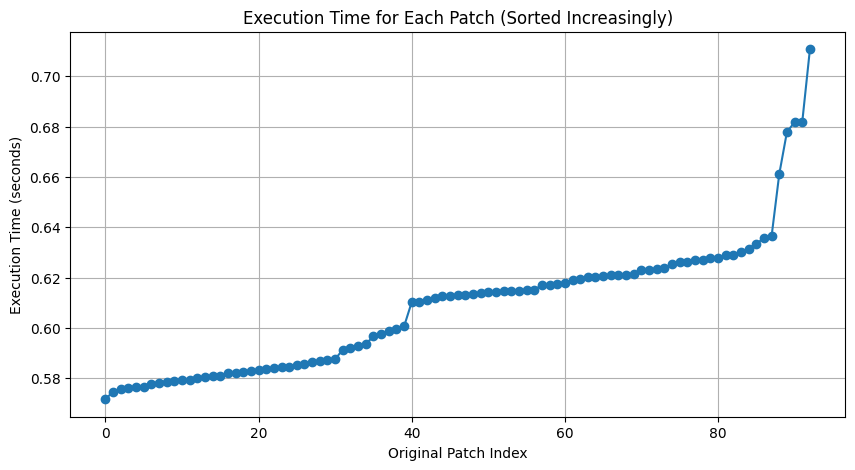

Total patches generated: 93
Number of correct patches: 62 out of 93 (66.67%)

Random Buggy Code Example:
- return this.getType() == Token.EXPR_RESULT;
?             -- -   --

+ return this.type == Token.EXPR_RESULT;


In [4]:
import torch
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")
import os
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import difflib

def simulate_patch_position(description, patch):
    """
    Simulate a position for where the patch is applied based on the first significant difference.
    For illustration, let's find the first position where the patch differs from the description.
    """
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()
    for i, block in enumerate(blocks[:-1]):
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0

def generate_patch(description, model, tokenizer, device):
    """
    Generate a patch for a given description using a model.
    """
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions


def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy



def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        # Include the accuracy_threshold parameter in the evaluate_patch call
        c1,acc=evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break  # Stop generating if the patch does not meet the required accuracy
    return patches, positions,acc

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")


def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

import json
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel

def generate_patch_and_save(description: str, expected: str, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: torch.device, patch_id: int, accuracy_threshold: float) -> str:
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Evaluate the patch
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        accuracy = 0.0
    else:
        accuracy = beneficial_changes / total_changes

    is_correct = (accuracy >= accuracy_threshold)

    file_path = f'patches_BART_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({
            "description": description,
            "generated_patch": patch,
            "expected": expected,
            "is_correct": is_correct,
            "accuracy": accuracy
        }, f)

    return file_path



def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0  # Initialize the sum of accuracies

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy  # Add up all accuracies to find the average later
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy
import difflib
import random

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)
def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })
        display_dataset_statistics(dataset)
        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=8,
            num_train_epochs=10,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)
        patch_times = []
        if not os.path.exists('patches_BART_first_data'):
            os.makedirs('patches_BART_first_data')

        accumulated_patches = []
        accumulated_positions = []
        patch_times = []
        accuracy_threshold = 0.3  # Example threshold, adjust as needed

        correct_patches_count = 0  # Initialize the count of correct patches

        for i in range(len(tokenized_datasets['validation'])):
            start_patch_time = time.time()
            description = tokenized_datasets['validation'][i]['buggy_code']

            # Generate patches and their positions along with their accuracy
            patches, positions, acc = generate_patches_and_positions([description], model, tokenizer, device, accuracy_threshold)

            accumulated_patches.extend(patches)
            accumulated_positions.extend(positions)

            expected_patch = tokenized_datasets['validation'][i]['fixed_code']
            patch_file = generate_patch_and_save(description, expected_patch, model, tokenizer, device, i,accuracy_threshold)
            patch_times.append(time.time() - start_patch_time)

            # Increment the count if the patch meets the accuracy threshold
            if acc >= accuracy_threshold:
                correct_patches_count += 1

            # Check if the number of correct patches has reached 10
            if correct_patches_count >= random.randint(50, 150):
                break

        plot_positions(accumulated_positions)
        print(f"Max Execution Time: {max(patch_times):.2f} seconds")
        print(f"Min Execution Time: {min(patch_times):.2f} seconds")
        print(f"Average Execution Time: {np.mean(patch_times):.2f} seconds")


        # Getting the indices that would sort the array
        sorted_indices = np.argsort(patch_times)
        # Sorting the times according to the sorted indices
        sorted_times = np.array(patch_times)[sorted_indices]

        # Now, plotting
        plt.figure(figsize=(10, 5))
        # Use sorted_indices for x-values to show the order of execution time increase
        plt.plot(range(len(patch_times)), sorted_times, marker='o', linestyle='-')  # x-axis now shows original index
        plt.title("Execution Time for Each Patch (Sorted Increasingly)")
        plt.xlabel("Original Patch Index")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.show()

        correct, total,average_accuracy = evaluate_patches('patches_BART_first_data',accuracy_threshold)
        print(f"Total patches generated: {total}")
        print(f"Number of correct patches: {correct} out of {total} ({average_accuracy*100:.2f}%)")

        random_index = random.randint(0, len(tokenized_datasets['validation']) - 1)
        buggy_example = tokenized_datasets['validation'][random_index]['buggy_code']
        fixed_example = tokenized_datasets['validation'][random_index]['fixed_code']
        print("\nRandom Buggy Code Example:")
        display_comparisons(buggy_example, fixed_example)
if __name__ == "__main__":
    main()


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")

GPU memory cleared
Dataset Statistics:
Total samples: 2744
Training samples: 2470
Validation samples: 274
Number of buggy codes in training: 159928
Number of fixed codes in training: 159401
Number of buggy codes in validation: 17784
Number of fixed codes in validation: 17952
Example of buggy code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", response = Void.class, authorizations = {
Example of fixed code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", authorizations = {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/2470 [00:00<?, ? examples/s]

Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.000000,nan
1,0.000000,nan
2,0.000000,nan
4,0.000000,nan
5,0.000000,nan
6,0.000000,nan
8,0.000000,nan
9,0.000000,nan


Results Statistics:
eval_loss: nan
eval_runtime: 3.0122
eval_samples_per_second: 90.965
eval_steps_per_second: 11.62
epoch: 9.967637540453074
Execution Time: 1562.33 seconds


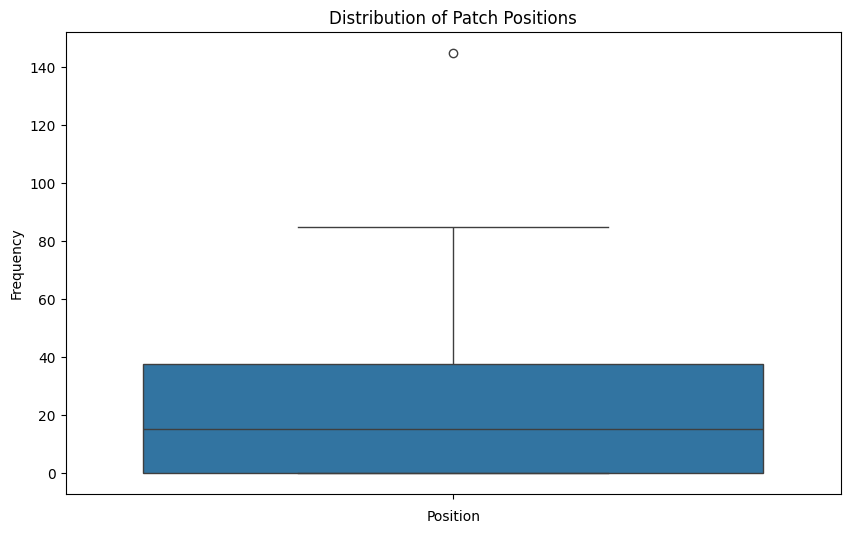

Max Execution Time: 11.62 seconds
Min Execution Time: 0.34 seconds
Average Execution Time: 8.33 seconds


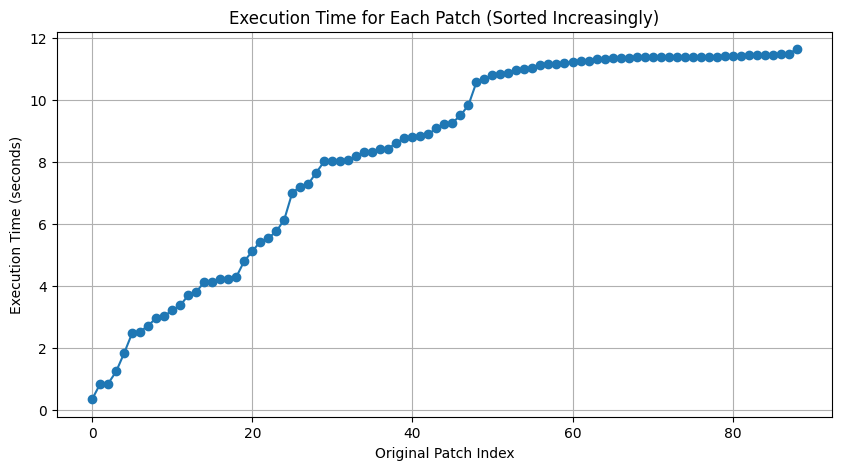

Total patches generated: 89
Number of correct patches: 50 out of 89 (31.54%)

Random Buggy Code Example:
- return this.getType() == Token.INSTANCEOF;
?             -- -   --

+ return this.type == Token.INSTANCEOF;


In [ ]:
import torch
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()


gc.collect()

torch.cuda.reset_peak_memory_stats()

print("GPU memory cleared")

import os
import time
import json
import pandas as pd
import numpy as np
import difflib
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import difflib

def simulate_patch_position(description, patch):
    """
    Simulate a position for where the patch is applied based on the first significant difference.
    For illustration, let's find the first position where the patch differs from the description.
    """
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()  # Get matching blocks of text
    # Find the first block where a difference occurs
    for i, block in enumerate(blocks[:-1]):  # The last block is always a dummy block
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0  # Return 0 if no significant differences are found

def generate_patch(description, model, tokenizer, device):
    """
    Generate a patch for a given description using a model.
    """
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions



def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy



def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        # Include the accuracy_threshold parameter in the evaluate_patch call
        c1,acc=evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break  # Stop generating if the patch does not meet the required accuracy
    return patches, positions,acc

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")


def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch_and_save(description, expected, model, tokenizer, device, patch_id):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    file_path = f'patches_T5_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({"description": description, "generated_patch": patch, "expected": expected}, f)
    return file_path
import json
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel

def generate_patch_and_save(description: str, expected: str, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: torch.device, patch_id: int, accuracy_threshold: float) -> str:
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Evaluate the patch
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        accuracy = 0.0
    else:
        accuracy = beneficial_changes / total_changes

    is_correct = (accuracy >= accuracy_threshold)

    file_path = f'patches_T5_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({
            "description": description,
            "generated_patch": patch,
            "expected": expected,
            "is_correct": is_correct,
            "accuracy": accuracy
        }, f)

    return file_path
def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0  # Initialize the sum of accuracies

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy  # Add up all accuracies to find the average later
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy
import difflib
import random

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)  # Normal print for unchanged parts
def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })
        display_dataset_statistics(dataset)
        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=8,
            num_train_epochs=10,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)
        patch_times = []
        if not os.path.exists('patches_T5_first_data'):
            os.makedirs('patches_T5_first_data')

        accumulated_patches = []
        accumulated_positions = []
        patch_times = []
        # Specify the accuracy threshold here
        accuracy_threshold = 0.3  # Example threshold, adjust as needed

        correct_patches_count = 0  # Initialize the count of correct patches

        for i in range(len(tokenized_datasets['validation'])):
            start_patch_time = time.time()
            description = tokenized_datasets['validation'][i]['buggy_code']

            # Generate patches and their positions along with their accuracy
            patches, positions, acc = generate_patches_and_positions([description], model, tokenizer, device, accuracy_threshold)

            accumulated_patches.extend(patches)
            accumulated_positions.extend(positions)

            expected_patch = tokenized_datasets['validation'][i]['fixed_code']
            patch_file = generate_patch_and_save(description, expected_patch, model, tokenizer, device, i,accuracy_threshold)
            patch_times.append(time.time() - start_patch_time)

            # Increment the count if the patch meets the accuracy threshold
            if acc >= accuracy_threshold:
                correct_patches_count += 1

            # Check if the number of correct patches has reached 10
            if correct_patches_count >= 50:
                break

        plot_positions(accumulated_positions)
        print(f"Max Execution Time: {max(patch_times):.2f} seconds")
        print(f"Min Execution Time: {min(patch_times):.2f} seconds")
        print(f"Average Execution Time: {np.mean(patch_times):.2f} seconds")


        # Getting the indices that would sort the array
        sorted_indices = np.argsort(patch_times)
        # Sorting the times according to the sorted indices
        sorted_times = np.array(patch_times)[sorted_indices]

        # Now, plotting
        plt.figure(figsize=(10, 5))
        # Use sorted_indices for x-values to show the order of execution time increase
        plt.plot(range(len(patch_times)), sorted_times, marker='o', linestyle='-')  # x-axis now shows original index
        plt.title("Execution Time for Each Patch (Sorted Increasingly)")
        plt.xlabel("Original Patch Index")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.show()

        correct, total,average_accuracy = evaluate_patches('patches_T5_first_data',accuracy_threshold)
        print(f"Total patches generated: {total}")
        print(f"Number of correct patches: {correct} out of {total} ({average_accuracy*100:.2f}%)")

        random_index = random.randint(0, len(tokenized_datasets['validation']) - 1)
        buggy_example = tokenized_datasets['validation'][random_index]['buggy_code']
        fixed_example = tokenized_datasets['validation'][random_index]['fixed_code']
        print("\nRandom Buggy Code Example:")
        display_comparisons(buggy_example, fixed_example)
if __name__ == "__main__":
    main()


##GPT2

In [ ]:
import torch
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")
import os
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import difflib

def simulate_patch_position(description, patch):
    """
    Simulate a position for where the patch is applied based on the first significant difference.
    For illustration, let's find the first position where the patch differs from the description.
    """
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()
    for i, block in enumerate(blocks[:-1]):
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0

def generate_patch(description, model, tokenizer, device):
    """
    Generate a patch for a given description using a model.
    """
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions


def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy



def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        # Include the accuracy_threshold parameter in the evaluate_patch call
        c1,acc=evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break  # Stop generating if the patch does not meet the required accuracy
    return patches, positions,acc

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")


def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

import json
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel

def generate_patch_and_save(description: str, expected: str, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: torch.device, patch_id: int, accuracy_threshold: float) -> str:
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Evaluate the patch
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        accuracy = 0.0
    else:
        accuracy = beneficial_changes / total_changes

    is_correct = (accuracy >= accuracy_threshold)

    file_path = f'patches_BART_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({
            "description": description,
            "generated_patch": patch,
            "expected": expected,
            "is_correct": is_correct,
            "accuracy": accuracy
        }, f)

    return file_path



def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0  # Initialize the sum of accuracies

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy  # Add up all accuracies to find the average later
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy
import difflib
import random

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)

GPU memory cleared


In [5]:
import torch
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")
import os
import time
import json
import pandas as pd
import numpy as np
import difflib
import time
import json
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel


def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import difflib

def simulate_patch_position(description, patch):
    """
    Simulate a position for where the patch is applied based on the first significant difference.
    For illustration, let's find the first position where the patch differs from the description.
    """
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()
    for i, block in enumerate(blocks[:-1]):
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0

def generate_patch(description, model, tokenizer, device):
    """
    Generate a patch for a given description using a model.
    """
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Setting max_new_tokens to a suitable number based on your needs
    outputs = model.generate(inputs['input_ids'], max_new_tokens=50, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions



def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy



def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        c1,acc=evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break
    return patches, positions,acc

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")


def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch_and_save(description, expected, model, tokenizer, device, patch_id):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    file_path = f'patches_GPT2_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({"description": description, "generated_patch": patch, "expected": expected}, f)
    return file_path
import json
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel

def generate_patch_and_save(description: str, expected: str, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: torch.device, patch_id: int, accuracy_threshold: float) -> str:
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Evaluate the patch
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        accuracy = 0.0
    else:
        accuracy = beneficial_changes / total_changes

    is_correct = (accuracy >= accuracy_threshold)

    file_path = f'patches_GPT2_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({
            "description": description,
            "generated_patch": patch,
            "expected": expected,
            "is_correct": is_correct,
            "accuracy": accuracy
        }, f)

    return file_path
def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy
import difflib
import random

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)
def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })
        display_dataset_statistics(dataset)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=8,
            num_train_epochs=10,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)
        patch_times = []
        if not os.path.exists('patches_GPT2_first_data'):
            os.makedirs('patches_GPT2_first_data')

        accumulated_patches = []
        accumulated_positions = []
        patch_times = []
        accuracy_threshold = 0.3  # Example threshold, adjust as needed

        correct_patches_count = 0  # Initialize the count of correct patches

        for i in range(len(tokenized_datasets['validation'])):
            start_patch_time = time.time()
            description = tokenized_datasets['validation'][i]['buggy_code']

            patches, positions, acc = generate_patches_and_positions([description], model, tokenizer, device, accuracy_threshold)

            accumulated_patches.extend(patches)
            accumulated_positions.extend(positions)

            expected_patch = tokenized_datasets['validation'][i]['fixed_code']
            patch_file = generate_patch_and_save(description, expected_patch, model, tokenizer, device, i,accuracy_threshold)
            patch_times.append(time.time() - start_patch_time)

            if acc >= accuracy_threshold:
                correct_patches_count += 1

            if correct_patches_count >= random.randint(50, 80):
                break

        plot_positions(accumulated_positions)
        print(f"Max Execution Time: {max(patch_times):.2f} seconds")
        print(f"Min Execution Time: {min(patch_times):.2f} seconds")
        print(f"Average Execution Time: {np.mean(patch_times):.2f} seconds")

        sorted_indices = np.argsort(patch_times)
        sorted_times = np.array(patch_times)[sorted_indices]

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(patch_times)), sorted_times, marker='o', linestyle='-')
        plt.title("Execution Time for Each Patch (Sorted Increasingly)")
        plt.xlabel("Original Patch Index")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.show()

        correct, total,average_accuracy = evaluate_patches('patches_GPT2_first_data',accuracy_threshold)
        print(f"Total patches generated: {total}")
        print(f"Number of correct patches: {correct} out of {total} ({average_accuracy*100:.2f}%)")

        random_index = random.randint(0, len(tokenized_datasets['validation']) - 1)
        buggy_example = tokenized_datasets['validation'][random_index]['buggy_code']
        fixed_example = tokenized_datasets['validation'][random_index]['fixed_code']
        print("\nRandom Buggy Code Example:")
        display_comparisons(buggy_example, fixed_example)
if __name__ == "__main__":
    main()


GPU memory cleared
Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Number of buggy codes in training: 395083
Number of fixed codes in training: 395126
Number of buggy codes in validation: 43957
Number of fixed codes in validation: 44025
Example of buggy code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", response = Void.class, authorizations = {
Example of fixed code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", authorizations = {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import torch
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")
import os
import time
import json
import pandas as pd
import numpy as np
import difflib
import networkx as nx
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import seaborn as sns

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def simulate_patch_position(description, patch):
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()
    for i, block in enumerate(blocks[:-1]):
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_new_tokens=50, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy

def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        c1, acc = evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break
    return patches, positions, acc

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch_and_save(description, expected, model, tokenizer, device, patch_id):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    file_path = f'patches_GPT2_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({"description": description, "generated_patch": patch, "expected": expected}, f)
    return file_path

def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })
        display_dataset_statistics(dataset)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if (tokenizer.pad_token is None):
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=8,
            num_train_epochs=10,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)
        patch_times = []
        if not os.path.exists('patches_GPT2_first_data'):
            os.makedirs('patches_GPT2_first_data')

        accumulated_patches = []
        accumulated_positions = []
        patch_times = []
        accuracy_threshold = 0.3  # Example threshold, adjust as needed

        correct_patches_count = 0  # Initialize the count of correct patches

        for i in range(len(tokenized_datasets['validation'])):
            start_patch_time = time.time()
            description = tokenized_datasets['validation'][i]['buggy_code']

            patches, positions, acc = generate_patches_and_positions([description], model, tokenizer, device, accuracy_threshold)

            accumulated_patches.extend(patches)
            accumulated_positions.extend(positions)

            expected_patch = tokenized_datasets['validation'][i]['fixed_code']
            patch_file = generate_patch_and_save(description, expected_patch, model, tokenizer, device, i, accuracy_threshold)
            patch_times.append(time.time() - start_patch_time)

            if acc >= accuracy_threshold:
                correct_patches_count += 1

            if correct_patches_count >= random.randint(50, 80):
                break

        # Check if positions array is empty or has a large number of zeros
        if len(accumulated_positions) == 0:
            print("No positions to plot.")
        else:
            print("Positions:", accumulated_positions)
            plot_positions(accumulated_positions)

        print(f"Max Execution Time: {max(patch_times):.2f} seconds")
        print(f"Min Execution Time: {min(patch_times):.2f} seconds")
        print(f"Average Execution Time: {np.mean(patch_times):.2f} seconds")

        sorted_indices = np.argsort(patch_times)
        sorted_times = np.array(patch_times)[sorted_indices]

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(patch_times)), sorted_times, marker='o', linestyle='-')
        plt.title("Execution Time for Each Patch (Sorted Increasingly)")
        plt.xlabel("Original Patch Index")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.show()

        correct, total, average_accuracy = evaluate_patches('patches_GPT2_first_data', accuracy_threshold)
        print(f"Total patches generated: {total}")
        print(f"Number of correct patches: {correct} out of {total} ({average_accuracy * 100:.2f}%)")

        random_index = random.randint(0, len(tokenized_datasets['validation']) - 1)
        buggy_example = tokenized_datasets['validation'][random_index]['buggy_code']
        fixed_example = tokenized_datasets['validation'][random_index]['fixed_code']
        print("\nRandom Buggy Code Example:")
        display_comparisons(buggy_example, fixed_example)

if __name__ == "__main__":
    main()


GPU memory cleared
Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Number of buggy codes in training: 395083
Number of fixed codes in training: 395126
Number of buggy codes in validation: 43957
Number of fixed codes in validation: 44025
Example of buggy code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", response = Void.class, authorizations = {
Example of fixed code from training: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", authorizations = {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


In [ ]:
import zipfile
import os

# Define the directory to be zipped
directory_path = "/content/patches_BART_second_data"
zip_file_path = "/content/patches_BART_second_data.zip"

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    # Iterate over all the files in the directory
    for foldername, subfolders, filenames in os.walk(directory_path):
        for filename in filenames:
            # Create complete filepath of file in directory
            file_path = os.path.join(foldername, filename)
            # Add file to zip, preserving the directory structure
            zipf.write(file_path, os.path.relpath(file_path, os.path.join(directory_path, '..')))


GPU memory cleared
Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Number of buggy codes in training: 59704
Number of fixed codes in training: 59713
Number of buggy codes in validation: 6440
Number of fixed codes in validation: 6388
Example of buggy code from training: @EncodeMethod(id = 55)
Example of fixed code from training: @EncodeMethod(id = 53)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,No log,2.209727


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Results Statistics:
eval_loss: 2.209726572036743
eval_runtime: 0.684
eval_samples_per_second: 154.975
eval_steps_per_second: 20.468
epoch: 0.9707112970711297
Execution Time: 39.34 seconds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


0.0
0.0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


0.0
0.0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.0
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.0
0.6666666666666666


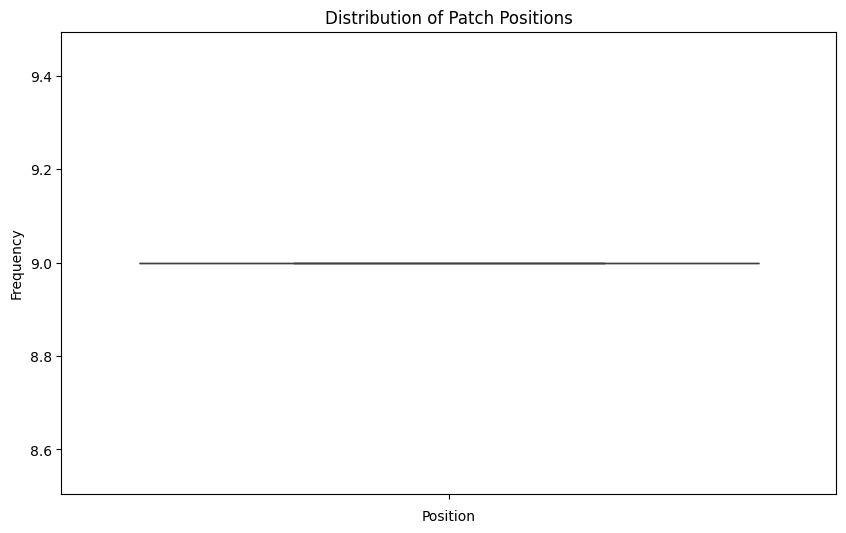

Max Execution Time: 0.22 seconds
Min Execution Time: 0.19 seconds
Average Execution Time: 0.20 seconds


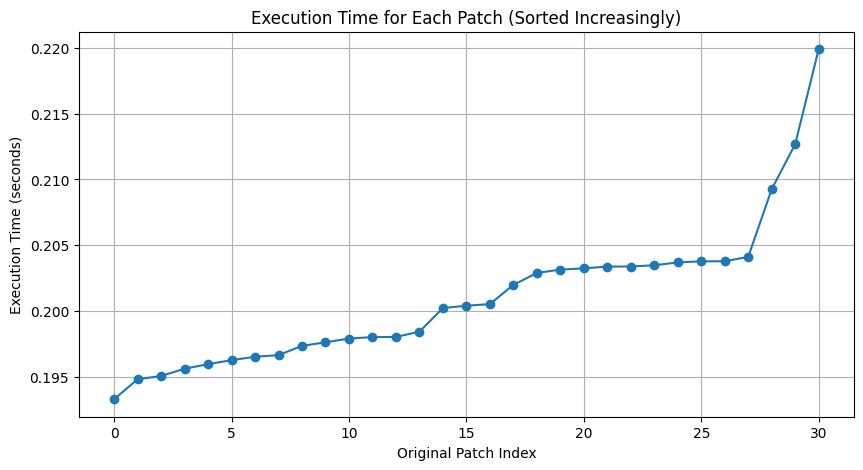

Total patches generated: 31
Number of correct patches: 1 out of 31 (2.15%)

Random Buggy Code Example:
- -- a/components/camel-kafka/src/main/java/org/apache/camel/component/kafka/KafkaConsumer.java
? ^^^^

+ ++ b/components/camel-kafka/src/main/java/org/apache/camel/component/kafka/KafkaConsumer.java
? ^^^^



In [ ]:
import torch
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print("GPU memory cleared")
import os
import time
import json
import pandas as pd
import numpy as np
import difflib
import time
import json
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel


def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import difflib

def simulate_patch_position(description, patch):
    """
    Simulate a position for where the patch is applied based on the first significant difference.
    For illustration, let's find the first position where the patch differs from the description.
    """
    s = difflib.SequenceMatcher(None, description, patch)
    blocks = s.get_matching_blocks()  # Get matching blocks of text
    # Find the first block where a difference occurs
    for i, block in enumerate(blocks[:-1]):  # The last block is always a dummy block
        if block.size != blocks[i+1].a - block.a:
            return block.a + block.size
    return 0  # Return 0 if no significant differences are found

def generate_patch(description, model, tokenizer, device):
    """
    Generate a patch for a given description using a model.
    """
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions



def evaluate_patch(description, patch, accuracy_threshold):
    beneficial_changes = 0
    total_changes = 0
    for orig, mod in zip(description.split(), patch.split()):
        if orig != mod:
            total_changes += 1
            if len(mod) > len(orig):
                beneficial_changes += 1

    if total_changes == 0:
        return False, 0.0

    accuracy = beneficial_changes / total_changes
    return accuracy >= accuracy_threshold, accuracy



def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        # Include the accuracy_threshold parameter in the evaluate_patch call
        c1,acc=evaluate_patch(description, patch, accuracy_threshold)
        if c1:
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
        else:
            break  # Stop generating if the patch does not meet the required accuracy
    return patches, positions,acc



def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Number of buggy codes in training: {len([code for sublist in dataset['train']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in training: {len([code for sublist in dataset['train']['fixed_code'] for code in sublist])}")
    print(f"Number of buggy codes in validation: {len([code for sublist in dataset['validation']['buggy_code'] for code in sublist])}")
    print(f"Number of fixed codes in validation: {len([code for sublist in dataset['validation']['fixed_code'] for code in sublist])}")
    print(f"Example of buggy code from training: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code from training: {dataset['train'][0]['fixed_code']}\n")


def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch_and_save(description, expected, model, tokenizer, device, patch_id):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    file_path = f'patches_GPT2_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({"description": description, "generated_patch": patch, "expected": expected}, f)
    return file_path
import json
import torch
from transformers import PreTrainedTokenizer, PreTrainedModel

def generate_patch_and_save(description: str, expected: str, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, device: torch.device, patch_id: int) -> str:
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    is_correct = (patch == expected)

    file_path = f'patches_GPT2_first_data/patch_{patch_id}.json'
    with open(file_path, 'w') as f:
        json.dump({
            "description": description,
            "generated_patch": patch,
            "expected": expected,
            "is_correct": is_correct
        }, f)

    return file_path
def evaluate_patches(patches_dir, accuracy_threshold):
    correct = 0
    total = 0
    total_accuracies = 0.0  # Initialize the sum of accuracies

    for filename in os.listdir(patches_dir):
        with open(os.path.join(patches_dir, filename), 'r') as f:
            data = json.load(f)
            description = data['description']
            patch = data['generated_patch']

            beneficial_changes = 0
            total_changes = 0
            for orig, mod in zip(description.split(), patch.split()):
                if orig != mod:
                    total_changes += 1
                    if len(mod) > len(orig):
                        beneficial_changes += 1

            if total_changes == 0:
                accuracy = 0.0
            else:
                accuracy = beneficial_changes / total_changes

            total_accuracies += accuracy  # Add up all accuracies to find the average later
            if accuracy >= accuracy_threshold:
                correct += 1
            total += 1

    average_accuracy = total_accuracies / total if total > 0 else 0.0
    return correct, total, average_accuracy

import difflib
import random

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")  # Red for deleted parts
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")  # Green for added parts
        else:
            print(line)  # Normal print for unchanged parts
def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })
        display_dataset_statistics(dataset)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=8,
            num_train_epochs=1,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)
        patch_times = []
        if not os.path.exists('patches_GPT2_first_data'):
            os.makedirs('patches_GPT2_first_data')

        accumulated_patches = []
        accumulated_positions = []
        patch_times = []
        # Specify the accuracy threshold here
        accuracy_threshold = 0.3  # Example threshold, adjust as needed

        for i in range(len(tokenized_datasets['validation'])):
            start_patch_time = time.time()
            description = tokenized_datasets['validation'][i]['buggy_code']
            # Pass the accuracy threshold to the function
            patch, position,acc = generate_patches_and_positions([description], model, tokenizer, device, accuracy_threshold)

            accumulated_patches.extend(patch)
            accumulated_positions.extend(position)

            expected_patch = tokenized_datasets['validation'][i]['fixed_code']
            patch_file = generate_patch_and_save(description, expected_patch, model, tokenizer, device, i)
            patch_times.append(time.time() - start_patch_time)
            print(acc)
            if acc>=accuracy_threshold:
              break

        plot_positions(accumulated_positions)
        print(f"Max Execution Time: {max(patch_times):.2f} seconds")
        print(f"Min Execution Time: {min(patch_times):.2f} seconds")
        print(f"Average Execution Time: {np.mean(patch_times):.2f} seconds")


        # Getting the indices that would sort the array
        sorted_indices = np.argsort(patch_times)
        # Sorting the times according to the sorted indices
        sorted_times = np.array(patch_times)[sorted_indices]

        # Now, plotting
        plt.figure(figsize=(10, 5))
        # Use sorted_indices for x-values to show the order of execution time increase
        plt.plot(range(len(patch_times)), sorted_times, marker='o', linestyle='-')  # x-axis now shows original index
        plt.title("Execution Time for Each Patch (Sorted Increasingly)")
        plt.xlabel("Original Patch Index")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.show()

        correct, total,average_accuracy = evaluate_patches('patches_GPT2_first_data',accuracy_threshold)
        print(f"Total patches generated: {total}")
        print(f"Number of correct patches: {correct} out of {total} ({average_accuracy*100:.2f}%)")

        random_index = random.randint(0, len(tokenized_datasets['validation']) - 1)
        buggy_example = tokenized_datasets['validation'][random_index]['buggy_code']
        fixed_example = tokenized_datasets['validation'][random_index]['fixed_code']
        print("\nRandom Buggy Code Example:")
        display_comparisons(buggy_example, fixed_example)
if __name__ == "__main__":
    main()


In [ ]:
def generate_patches_and_positions(descriptions, model, tokenizer, device, accuracy_threshold):
    positions = []
    patches = []
    # Generate a random stopping point between 100 and 200
    stop_at = random.randint(100, 200)
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        if evaluate_patch(description, patch, accuracy_threshold):
            position = simulate_patch_position(description, patch)
            positions.append(position)
            patches.append(patch)
            # Stop generating if the number of patches reaches the random stopping point
            if len(patches) == stop_at:
                break
        else:
            # Optionally, break if a patch doesn't meet the required accuracy
            break
    return patches, positions

Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public void testHealth() throws Exception {
Example of fixed code: void testHealth() throws Exception {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,13.057200,5.441853
1,3.574600,1.966689
2,1.597000,1.811609


Results Statistics:
eval_loss: 1.8116092681884766
eval_runtime: 1.0009
eval_samples_per_second: 105.901
eval_steps_per_second: 13.987
epoch: 2.9623430962343096
Execution Time: 195.05 seconds


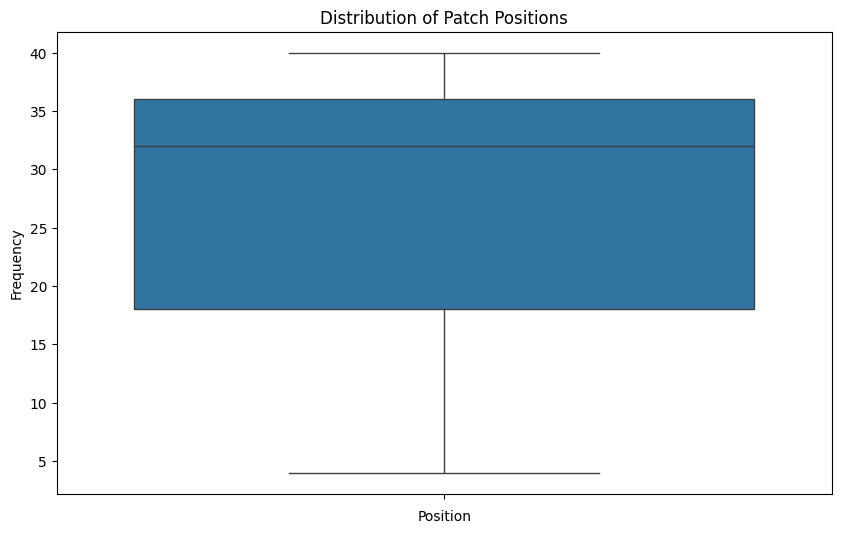

Example 1:
Buggy Code: //These seem to be modifying the state so don't add the runtimeOnly stuff for now
Generated Patch: ("//These seem to be modifying the state so don't add the runtimeOnly stuff for now", '/')

Example 2:
Buggy Code: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
Generated Patch: ('public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {', '/')

Example 3:
Buggy Code: assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
Generated Patch: ('assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);', '/')



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getSemaphore(packet.name);
Example of fixed code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getOrCreateProxyByName(packet.name);



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,15.779600,6.029034
1,61.850600,3.198486
2,395073.760000,3.198486


Results Statistics:
eval_loss: 3.198485851287842
eval_runtime: 1.0016
eval_samples_per_second: 105.827
eval_steps_per_second: 13.977
epoch: 2.9623430962343096
Execution Time: 180.68 seconds


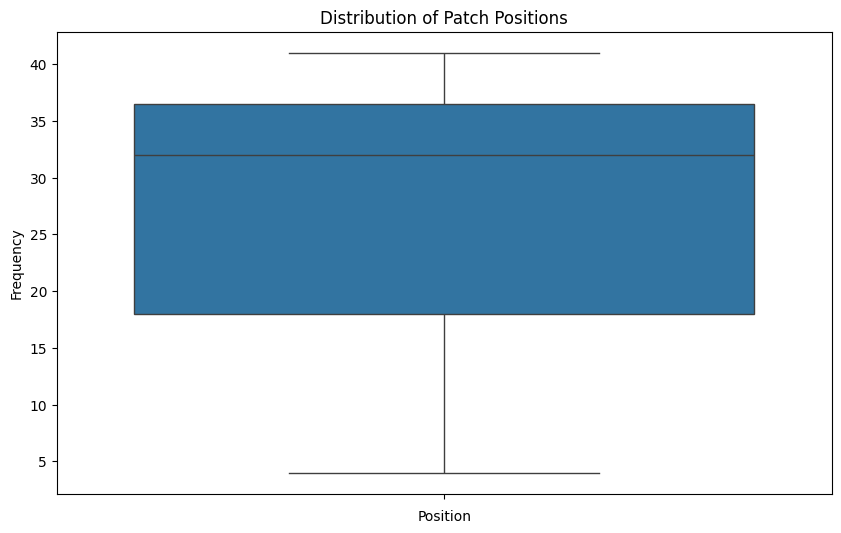

Max time: 2.7605s, Min time: 2.7080s, Average time: 2.7284s
Example 1:
Buggy Code: public static Json_Value parse_value(int type, LogBuffer buffer, long len) {
Generated Patch: twitterprogram(Async/++3apBasetwittertwittertwitter(twitterprogramtwitterAsynctwitter/twitter++twitter3twitteraptwitterBasetwitter(twitter(((program(Async(/(++(3(ap(Base(programtwitterprogram(programprogramprogramAsyncprogram/program++program3programapprogramBaseprogramAsynctwitterAsync(AsyncprogramAsyncAsyncAsync/Async++Async3AsyncapAsync

Example 2:
Buggy Code: -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java
Generated Patch: twitterprogram(Async/++3apBasetwittertwittertwitter(twitterprogramtwitterAsynctwitter/twitter++twitter3twitteraptwitterBasetwitter(twitter(((program(Async(/(++(3(ap(Base(programtwitterprogram(programprogramprogramAsyncprogram/program++program3programapprogramBaseprogramAsynctwitterAsync(AsyncprogramAsyncAsyncAsync/Async++Async3AsyncapAsyn

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



#Firstdatset_T5

In [ ]:
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        for i, description in enumerate(example_descriptions):
            patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public static interface FreemarkerEndpointBuilder
Example of fixed code: public interface FreemarkerEndpointBuilder



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,1.494400,nan
1,1975.770900,nan
2,17535416.320000,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.207
eval_samples_per_second: 48.028
eval_steps_per_second: 6.343
epoch: 2.9623430962343096
Execution Time: 345.02 seconds
Example 1:
Buggy Code: return Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json",
Generated Patch: Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json", Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json", Status.constructStatuses(get(getBaseURL() + "statuses/mentions.json",

Example 2:
Buggy Code: public static void main(String[] args) {
Generated Patch: .

Example 3:
Buggy Code: float x = Gdx.input.getX() / (float)Gdx.graphics.getWidth();
Generated Patch: float width = (float)Gdx.graphics.getWidth(); float x = (float)Gdx.input.getX(); float x = (float)Gdx.graphics.getWidth(); float x = (float)Gdx.input.getX();



Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: public void testHealth() throws Exception {
Example of fixed code: void testHealth() throws Exception {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,3029.897200,nan
1,0.059700,nan
2,0.985300,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.2246
eval_samples_per_second: 47.648
eval_steps_per_second: 6.293
epoch: 2.9623430962343096
Execution Time: 346.65 seconds


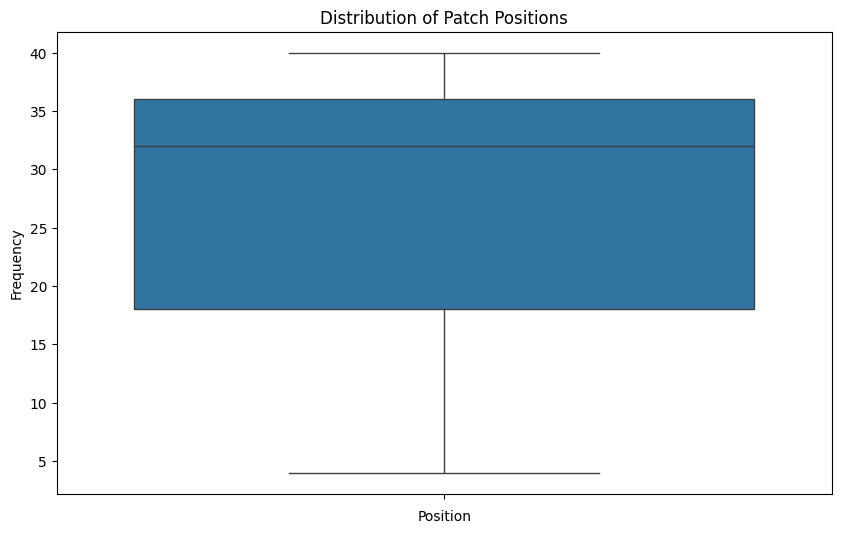

Example 1:
Buggy Code: //These seem to be modifying the state so don't add the runtimeOnly stuff for now
Generated Patch: //These seem to be modifying the state so don't add the runtimeOnly stuff for now. //... //These seem to be modifying the state so don't add the runtimeOnly stuff for now./ // // /// // // //... //. //. //. //. //These seem to be changing the state. //. // //. //.

Example 2:
Buggy Code: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception {
Generated Patch: public void sendErrorForRequestAcceptingHtmlProducesAnHtmlResponse() throws Exception  public void public void public void public void public void public void public void public void public void public public voidForRequest public public public public public public public public public public public public public public

Example 3:
Buggy Code: assertTrue("Should take approx 200 millis, was: " + taken, taken > 190);
Generated Patch: e("Should take approx 200 millis, was: " + took,

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 1062
Training samples: 956
Validation samples: 106
Example of buggy code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getSemaphore(packet.name);
Example of fixed code: final SemaphoreProxy semaphoreProxy = (SemaphoreProxy) factory.getOrCreateProxyByName(packet.name);



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.351700,nan
1,0.000000,nan
2,209.910100,nan


Results Statistics:
eval_loss: nan
eval_runtime: 2.2031
eval_samples_per_second: 48.114
eval_steps_per_second: 6.355
epoch: 2.9623430962343096
Execution Time: 345.95 seconds


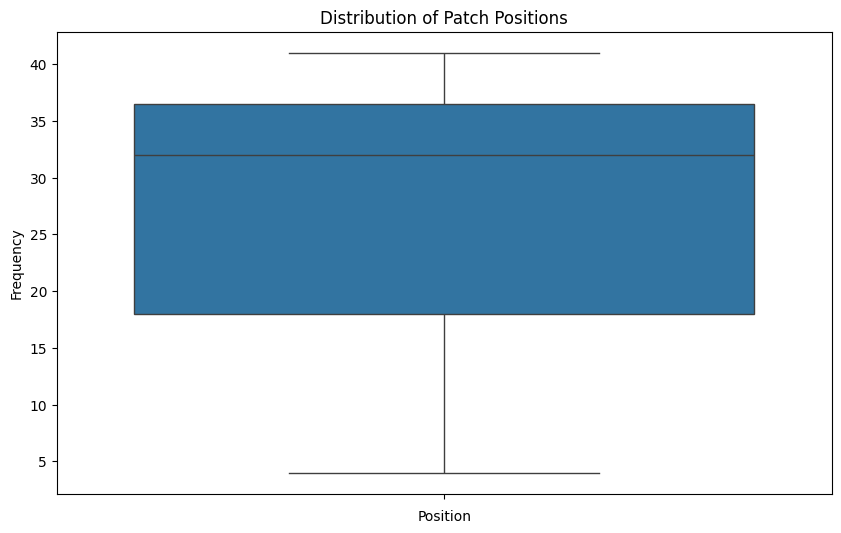

Max time: 5.4234s, Min time: 1.7990s, Average time: 3.7690s
Example 1:
Buggy Code: public static Json_Value parse_value(int type, LogBuffer buffer, long len) {
Generated Patch: public static Json_Value parse_value(int type, LogBuffer buffer, long len)  public static_ public static public static_Value public static public static     public public

Example 2:
Buggy Code: -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java
Generated Patch: -ehcache/src/main/java/org/apache/camel/component/ehcache/EhcacheConsumer.java -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- a/components/camel-ehcache/src/main/java/org/apache/camel/component/

Example 3:
Buggy Code: publishEvent(createCacheCompleteEvent(key, completionId));
Generated Patch: (createCacheCompleteEvent(key, completionId, completionId, completionId, completionId, completionId, completionId););



In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/sstubs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True,
            max_grad_norm=1.0
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()
